In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from sklearn.utils import resample

In [2]:
def get_df(path: str) -> pd.DataFrame:
    with open(path, 'r') as file:
        content = file.readlines()
    data = [line[:-1].split('\t') for line in content]
    df = pd.DataFrame(data=data, columns=['TITLE', 'CATEGORY'])
    # df.set_index('ID', inplace=True, drop=True)
    return df

train_df = get_df('../data/train.txt')
val_df = get_df('../data/valid.txt')
test_df = get_df('../data/test.txt')

# Preprocess

In [3]:
# upsample health
n_surp_sample = 500
health = train_df[train_df["CATEGORY"] == "health"]
health_upsample = resample(health, random_state = 35, n_samples=n_surp_sample, replace = True)

# upsample science_and_technology
n_love_sample = 250
tech = train_df[train_df["CATEGORY"] == "science_and_technology"]
tech_upsample = resample(tech, random_state = 35, n_samples=n_love_sample, replace = True)

train_df = pd.concat([train_df, health_upsample, tech_upsample])

### Lower case

In [4]:
train_df["TITLE"] = train_df["TITLE"].str.lower()
val_df["TITLE"] = val_df["TITLE"].str.lower()
test_df["TITLE"] = test_df["TITLE"].str.lower()

### Remove punctuation

In [5]:
def remove_punctuation(text):
  return re.sub(r'[^\w\s]', '', text)
  
train_df["TITLE"] = train_df["TITLE"].apply(lambda text: remove_punctuation(text))
val_df["TITLE"] = val_df["TITLE"].apply(lambda text: remove_punctuation(text))
test_df["TITLE"] = test_df["TITLE"].apply(lambda text: remove_punctuation(text))

### Vectorize

In [6]:
# Using TfidfVectorizer
# ex: "become overwhelmed defeated"
# sparse vector: [[988, 0.152], [2615, 0.651], [6114, 0.823]]
# 988 is value of "become" in vocabulary
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df["TITLE"])
X_val = vectorizer.transform(val_df["TITLE"])
X_test = vectorizer.transform(test_df["TITLE"])

### Encode labels

In [7]:
# {"anger": 1, "fear": 2, "happy": 3, "love": 4, "sadness": 5, "surprise": 6}
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train = encoder.fit_transform(np.array(train_df.CATEGORY).reshape(-1,1))
encoder = LabelEncoder()
y_val = encoder.fit_transform(np.array(val_df.CATEGORY).reshape(-1,1))
encoder = LabelEncoder()
y_test = encoder.fit_transform(np.array(test_df.CATEGORY).reshape(-1,1))

/Users/admin/Desktop/vscode/langchain-qdrant/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/Desktop/vscode/langchain-qdrant/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/Desktop/vscode/langchain-qdrant/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Train

In [8]:
import time

### KNN

In [9]:
# K Nearest Neighbor
from sklearn.neighbors import KNeighborsClassifier

classifier_knn = KNeighborsClassifier(n_neighbors=7, weights="distance")
t = time.time()
classifier_knn.fit(X_train,y_train)
time_for_train_knn = time.time()-t
print(f'Time Taken using TfidfVectorizer: {time_for_train_knn} seconds')

Time Taken using TfidfVectorizer: 0.0010418891906738281 seconds


## SVM

In [10]:
# Soft Margin Suport Vector Machine
from sklearn.svm import SVC

# svm linear
classifier_svm_linear = SVC(C = 1,kernel = 'linear')
t = time.time()
classifier_svm_linear.fit(X_train, y_train)
time_for_train_svm_linear = time.time()-t
print(f'linear SVM Taken: {time_for_train_svm_linear} seconds')

linear SVM Taken: 7.151152849197388 seconds


# Đánh giá mô hình

In [11]:
# evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
class_names = encoder.classes_

def model_Evaluate(model, X_test, y_test):

    t = time.time()
    y_pred = model.predict(X_test)
    t = time.time() - t
    print(f'Prediction time: {t/len(y_pred)}')
    print(classification_report(y_test, y_pred))

    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_predictions(
            y_test,
            y_pred,
            display_labels=class_names,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)
        plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
        plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)

## KNN

Prediction time: 0.0001747573631397192
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       552
           1       0.92      0.98      0.95       522
           2       0.81      0.74      0.78        89
           3       0.76      0.60      0.67       148

    accuracy                           0.89      1311
   macro avg       0.85      0.81      0.83      1311
weighted avg       0.89      0.89      0.89      1311



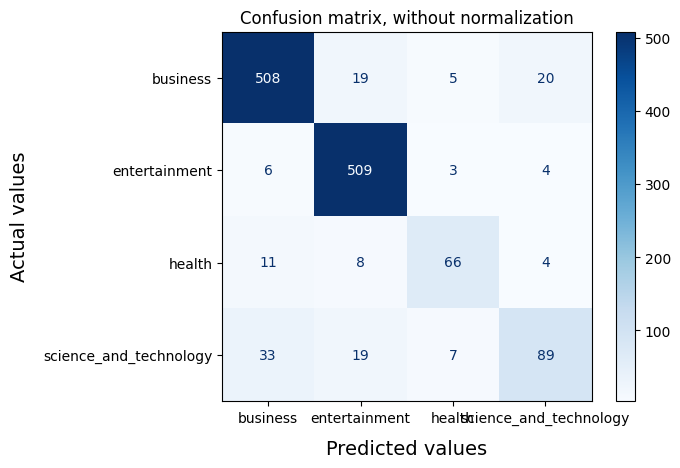

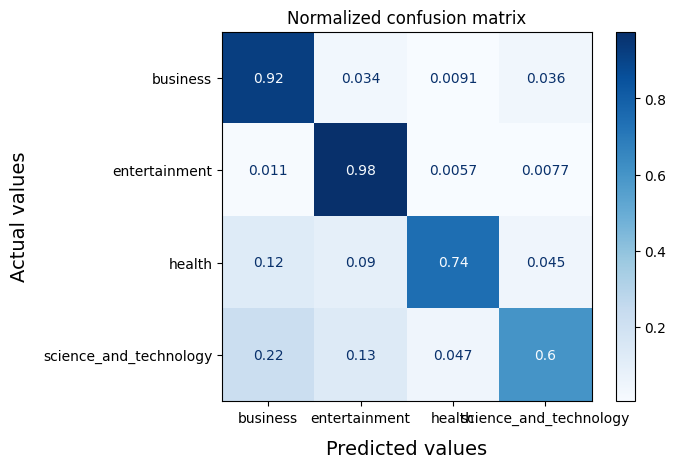

In [12]:
# KNN model using Count Vectorizer
model_Evaluate(classifier_knn, X_test, y_test)

## SVM

Prediction time: 0.00048137002096750823
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       552
           1       0.92      0.99      0.95       522
           2       0.93      0.72      0.81        89
           3       0.79      0.63      0.70       148

    accuracy                           0.91      1311
   macro avg       0.89      0.82      0.85      1311
weighted avg       0.90      0.91      0.90      1311



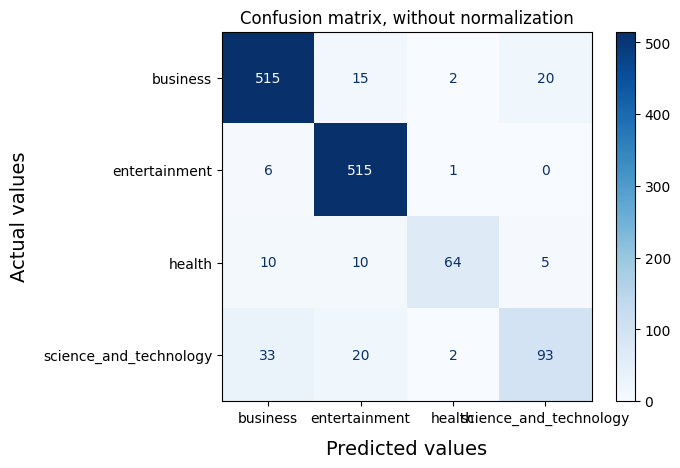

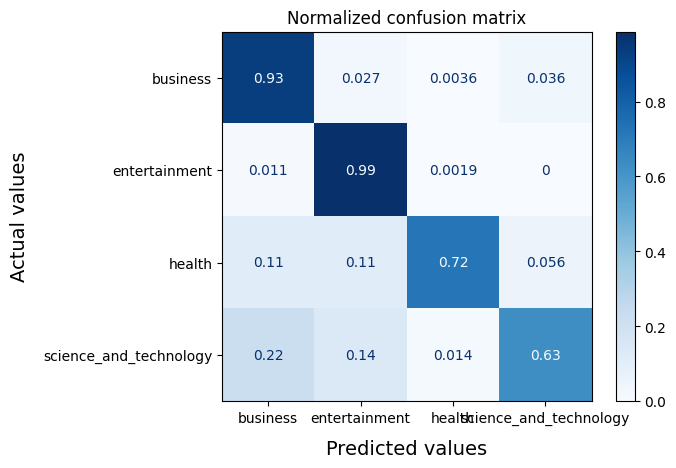

In [13]:
# Tfidf Vectorizer
model_Evaluate(classifier_svm_linear, X_test, y_test)